# Лабораторная работа №2. Многослойный перцептрон
Необходимо реализовать многослойный перцептрон для решения задач классификации. Для реализации можно использовать любые библиотеки и инструменты, которые позволяют выполнить условия данной лабораторной работы



# Необходимо продемонстрировать работу следующих сценариев: 

1) По количеству классов: малое(2-3) - *diabetes.csv* и *dataset2*, среднее(7-10), большое (~30)

2) По разделимости классов: линейно разделимое множество, линейно неразделимое множество (*dataset2*) (средняя площадь пересечения классов 10-20%), линейно неразделимое множество (средняя площадь пересечения классов 50-70%)

3) По качеству обучения: переобучение, недообучение, паралич сети

4) На эталонных множествах с количеством признаков более 5

5) По кодированию ответа в выходном слое

# Графики качества обучения
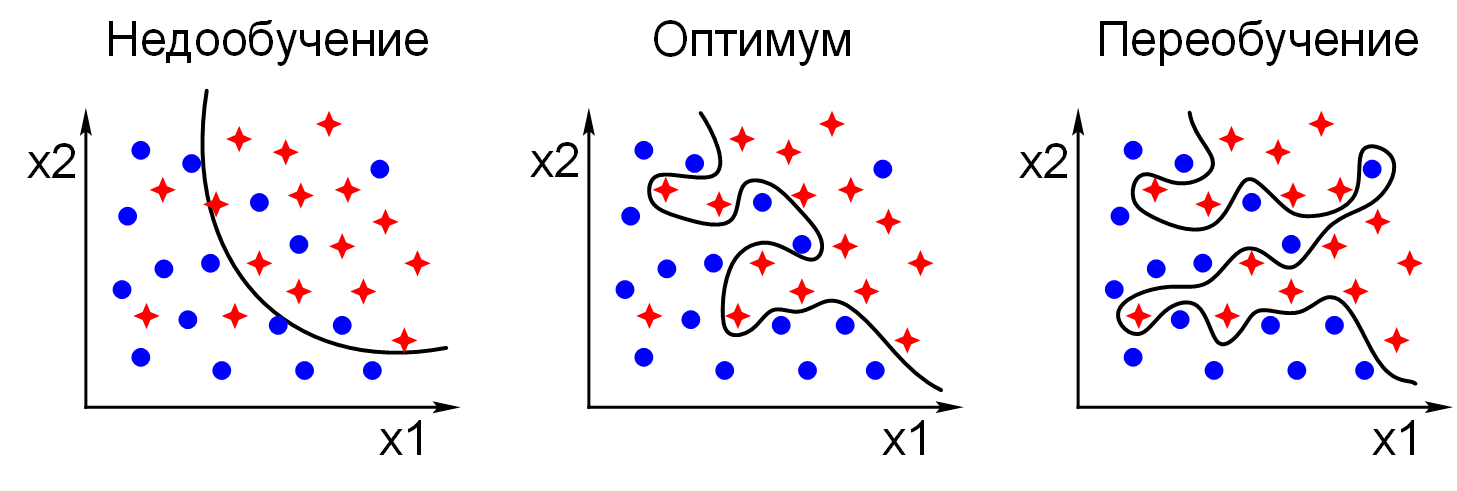

# Причины переобучения
> слишком мало данных для обучения либо слишком много нейронов и синапсов в ИНС – модель запомнила все варианты из обучающей выборки и, таким образом, утратила возможность обобщения, выдавая запомненные варианты вместо предсказаний;

> слишком долгое обучение – модель находит закономерности в шуме

> плохо подготовленные данные в обучающей выборке могут привести к тому, что модель будет давать большую ошибку на новых данных, которые не участвовали в обучении.

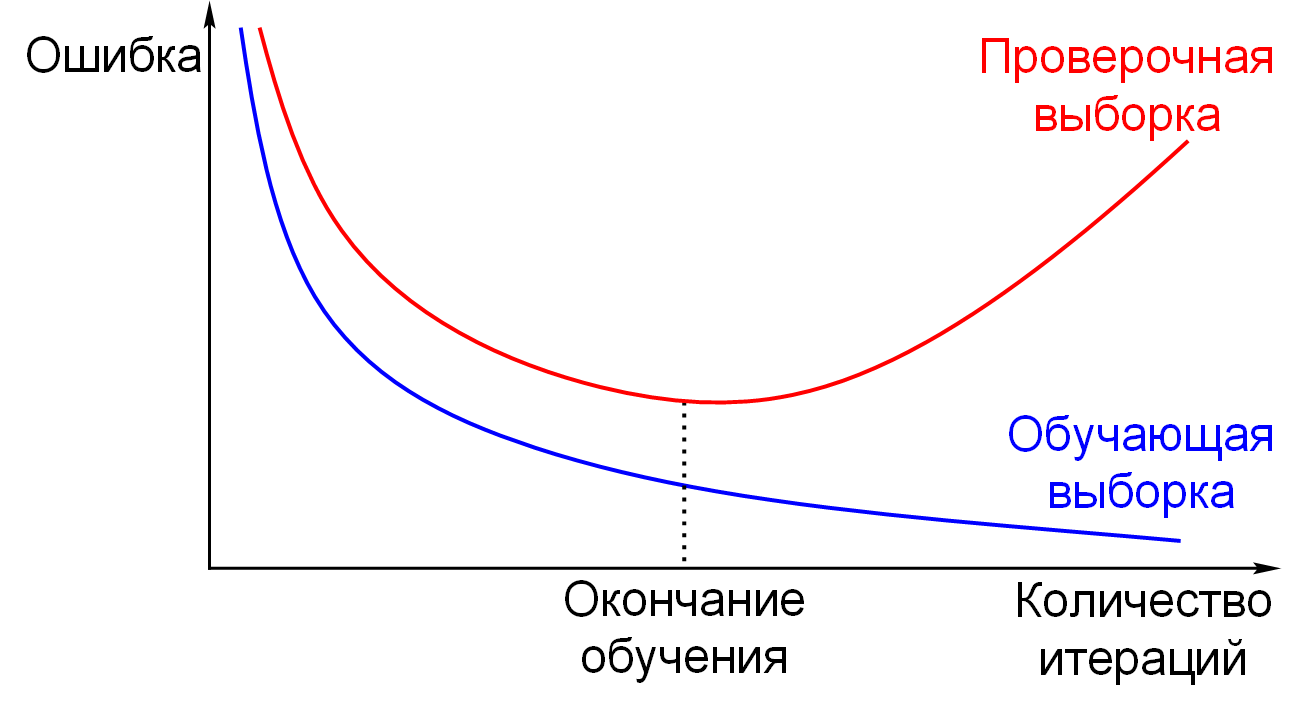

# Недообучение
Недообучение - явление, при котором ошибка обученной модели оказывается слишком большой. Недообучение возникает при использовании слишком простых моделей, как правило, с малым количеством нейронов и синапсов, либо при прекращении процесса обучения до достижения состояния с достаточно малой ошибкой, либо при неудачной обучающей выборке.

# Паралич сети
Паралич сети возникает при неограниченном увеличении весов. Аргумент
функции активации попадает в область, где функция активации имеет горизонтальную асимптоту, производная функции активации стремится к нулю, в результате веса не модифицируются, и сеть «застревает» в таком положении.

In [0]:
import torch
import numpy as np
from torch import from_numpy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# Загрузка данных из diabetes.csv
Данные содержат 8 атрибутов и 2 класса - 0 и 1.

In [0]:
xy = np.loadtxt('./diabetes.csv',
                        delimiter=',', dtype=np.float32)
np.random.shuffle(xy)
#x_data = torch.FloatTensor(from_numpy(xy[:, 0:-1])).to(device)
#y_data = torch.FloatTensor(from_numpy(xy[:, [-1]])).to(device)

X_train, X_test, X_val = np.split(xy, [int(.8 * len(xy)), int(.9 * len(xy))])

x_train = torch.FloatTensor(from_numpy(X_train[:, 0:-1])).to(device)
x_test = torch.FloatTensor(from_numpy(X_test[:, 0:-1])).to(device)
x_val = torch.FloatTensor(from_numpy(X_val[:, 0:-1])).to(device)

y_train = torch.FloatTensor(from_numpy(X_train[:, [-1]])).to(device)
y_test = torch.FloatTensor(from_numpy(X_test[:, [-1]])).to(device)
y_val = torch.FloatTensor(from_numpy(X_val[:, [-1]])).to(device)


# Создание модели
1 слой - линейный (применяет линейное преобразование к входным данным )

> 8 нейронов на входе, 4 на выходе

> функция активации - сигмоидальная

> Предусмотрен единичный вход


2 слой - линейный


> 4 нейрона на входе, 1 на выходе

> функция активации - сигмоидальная

> Предусмотрен единичный вход



In [0]:
# nn layers
linear1 = torch.nn.Linear(8, 4, bias=True)
linear2 = torch.nn.Linear(4, 1, bias=True)
sigmoid = torch.nn.Sigmoid()
relu = torch.nn.ReLU()

In [0]:
# model
model = torch.nn.Sequential(linear1, sigmoid, linear2, sigmoid).to(device)

In [0]:
#зададим функцию потерь и оптимизатор
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

Функция для вычисления метрик модели - accuracy, precision, recall


In [0]:
def find_metrics(model, x_data, y_data):
  with torch.no_grad():
      hypothesis = model(x_train)
      predicted = (hypothesis > 0.5).float()
      
      precision = precision_score(y_train, predicted)
      recall = recall_score(y_train, predicted)
      accuracy_m = accuracy_score(y_train, predicted)
      accuracy = (predicted == y_train).float().mean()
      
      print('\nAccuracy: ', accuracy_m, ' | Precision: ', precision, ' | Recall: ', recall)
      return accuracy, precision, recall

In [12]:
accuracy=[]
precision=[]
recall=[]
error = []
error_val = []
epochs = 10000
for step in range(epochs):
    #===Train data===#
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)

    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    error.append(loss.item())

    #===Validation data===#
    model.eval()
    optimizer.zero_grad()
    y_pred = model(x_val)

    loss = criterion(y_pred, y_val)
    loss.backward()
    optimizer.step()
    error_val.append(loss.item())

    if step % 1000 == 0:
      model.eval()
      print("\nStep: ", step,' ', " | Loss: ", loss.item())
      acc, pr, rc = find_metrics(model, x_train, y_train)
      accuracy.append(acc)
      precision.append(pr)
      recall.append(rc)


Step:  0    | Loss:  0.7344463467597961

Accuracy:  0.3443163097199341  | Precision:  0.0  | Recall:  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Step:  1000    | Loss:  0.4289742410182953

Accuracy:  0.7611202635914333  | Precision:  0.7842696629213484  | Recall:  0.8768844221105527

Step:  2000    | Loss:  0.3953419029712677

Accuracy:  0.7611202635914333  | Precision:  0.7935034802784223  | Recall:  0.8592964824120602

Step:  3000    | Loss:  0.3856954276561737

Accuracy:  0.7561779242174629  | Precision:  0.7962085308056872  | Recall:  0.8442211055276382

Step:  4000    | Loss:  0.3719596564769745

Accuracy:  0.7578253706754531  | Precision:  0.8009592326139089  | Recall:  0.8391959798994975

Step:  5000    | Loss:  0.34949401021003723

Accuracy:  0.7512355848434926  | Precision:  0.8004866180048662  | Recall:  0.8266331658291457

Step:  6000    | Loss:  0.3239753246307373

Accuracy:  0.7578253706754531  | Precision:  0.8024096385542169  | Recall:  0.8366834170854272

Step:  7000    | Loss:  0.30277398228645325

Accuracy:  0.7759472817133443  | Precision:  0.8164251207729468  | Recall:  0.8492462311557789

Step:  8000    | 

Построим графики полученных метрик с помощью библиотеки *matplotlib*

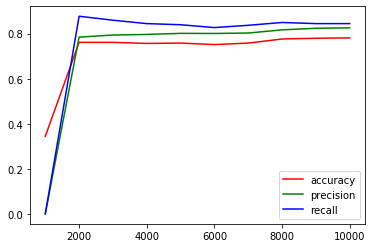

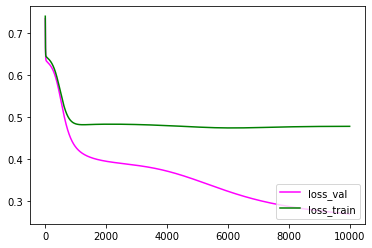

In [13]:
import matplotlib.pyplot as plt
step = 1000
x = [i for i in range(step, epochs+step, step)]
plt.plot(x, accuracy, color='red', label='accuracy')
plt.plot(x, precision, color = 'green', label='precision')
plt.plot(x, recall, color = 'blue', label='recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

x = [i for i in range(epochs)]
plt.plot(x, error_val, color = 'magenta', label='loss_val')
plt.plot(x, error, color = 'green', label='loss_train')
plt.legend(loc='lower right')
plt.show()

На графике видно, что на обучающем множестве ошибка -> 0, в то время как на тестовом она примерно равна 0,5. Из этого следует, что сеть переобучилась

# Сгенерируем новые данные dataset_2
Кол-во классов: 4, кол-во аттрибутов: 2, линейно-неразделимое множество

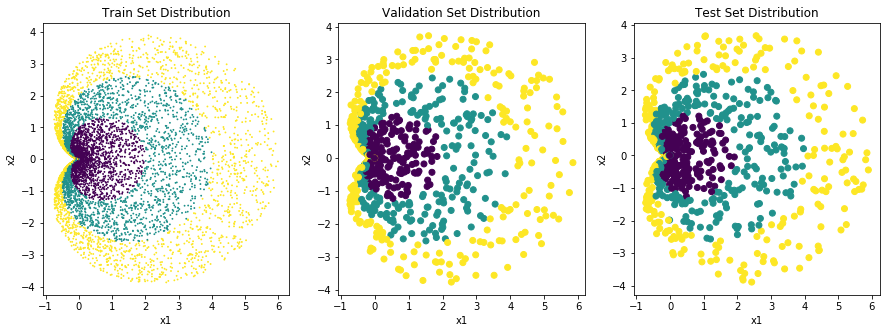

In [14]:
# Сгенерируем датасет
r = np.random.rand(10000)*3
theta = np.random.rand(10000)*2*np.pi
y = r.astype(int)
r = r * (np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

# Разделение на train, val, test
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# Выведем график данных для каждой выборки
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')


ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')

plt.show()

In [0]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [0]:
loss_cel = nn.CrossEntropyLoss()
model = MLPModel() 
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [17]:
epochs = 1000
step = 200
def train(model,epochs,step, train_X, train_y, val_X, val_y):
  accuracy = []
  precision = []
  recall = []
  error = []
  error_val = []
  for i in range(epochs):
    #===Train data===#
    model.train()
    optimizer.zero_grad()
    
    input_x = torch.tensor(train_X).float()
    true_y = torch.tensor(train_y).long()
    pred_y = model(input_x)
    loss = loss_cel(pred_y, true_y)
    loss.backward()
    optimizer.step()
    error.append(loss.item())

    #===Validation data===#
    model.eval()
    optimizer.zero_grad()
    
    input_x = torch.tensor(val_X).float()
    true_y = torch.tensor(val_y).long()
    pred_y = model(input_x)
    loss = loss_cel(pred_y, true_y)
    loss.backward()
    optimizer.step()
    error_val.append(loss)

    if i % step == 0:
        model.eval()
        optimizer.zero_grad()
        input_x = torch.tensor(test_X).float()
        true_y = torch.tensor(test_y).long()
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        acc = accuracy_score(true_y, pred_y)
        pr = precision_score(true_y, pred_y, average='weighted')
        rc = recall_score(true_y, pred_y, average='weighted')
        
        accuracy.append(acc)
        precision.append(pr)
        recall.append(rc)
        
        print("\nEpoch: ", i, "| Accuracy: ", acc, "| Precision: ", pr, "| Recall: ", rc, "| Loss: ", loss.item())
  return accuracy, precision, recall, error, error_val
accuracy, precision, recall, error, error_val = train(model, epochs,step, train_X, train_y, val_X, val_y)


Epoch:  0 | Accuracy:  0.39 | Precision:  0.36587724245985115 | Recall:  0.39 | Loss:  1.0364325046539307

Epoch:  200 | Accuracy:  0.775 | Precision:  0.7865616055262977 | Recall:  0.775 | Loss:  0.6331617832183838

Epoch:  400 | Accuracy:  0.795 | Precision:  0.8037358088962875 | Recall:  0.795 | Loss:  0.573871374130249

Epoch:  600 | Accuracy:  0.809 | Precision:  0.8177585707981339 | Recall:  0.809 | Loss:  0.5451778769493103

Epoch:  800 | Accuracy:  0.821 | Precision:  0.8289138979334175 | Recall:  0.821 | Loss:  0.5257877111434937


[0.39, 0.775, 0.795, 0.809, 0.821]


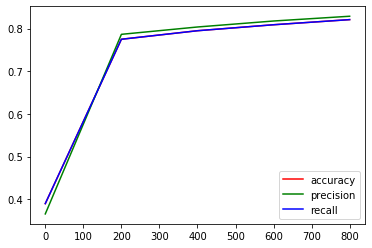

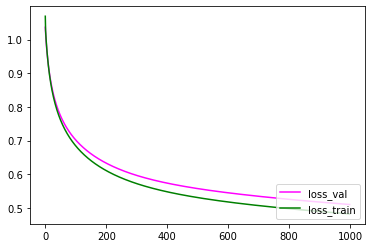

In [18]:
def plot_metrics_error(step, epochs, accuracy, precision, recall, error_val, error):
  x = [i for i in range(0, epochs, step)]
  print(accuracy)
  plt.plot(x, accuracy, color='red', label='accuracy')
  plt.plot(x, precision, color = 'green', label='precision')
  plt.plot(x, recall, color = 'blue', label='recall')
  plt.legend(loc='lower right')
  plt.show()
  plt.close()

  x = [i for i in range(epochs)]
  plt.plot(x, error_val, color = 'magenta', label='loss_val')
  plt.plot(x, error, color = 'green', label='loss_train')
  plt.legend(loc='lower right')
  plt.show()

plot_metrics_error(step, epochs, accuracy, precision, recall, error_val, error)

# Сгенерируем новые данные dataset_3 
Кол-во классов: 10, линейно-разделимое множество

In [0]:
from sklearn.datasets import make_blobs
def generate_center_clusters(classes_numb = 5,
                     low_bound = -100,
                     high_bound = 100,
                     intercluster_dist = 5,
                     dim = 3,
                     low_bound_points_in_cluster = 150,
                     high_bound_points_in_cluster = 200):
    
    low_bound = low_bound  / (10/classes_numb)
    high_bound = high_bound  / (10/classes_numb)
    center_list = []
    center_list.append(np.array(np.random.uniform(low_bound, high_bound, dim)))
    for i in range(classes_numb-1):
        flag_correct = False
        while flag_correct == False: 
            flag_correct = True
            point_coord = np.array(np.random.uniform(low_bound, high_bound, dim))
            for i in range(len(center_list)):
                flag_correct *= np.linalg.norm(center_list[i]-point_coord) > intercluster_dist
        center_list.append(point_coord)
    return center_list, dim, intercluster_dist

def generate_data(center_list,
                  dim,
                  intercluster_dist,
                  low_bound_points_in_cluster=150,
                  high_bound_points_in_cluster=500,
                  alpha_coef=0.0):
    cluster_std = intercluster_dist * (0.66 + alpha_coef*dim) 
    X, Y = make_blobs(n_samples=np.random.randint(low_bound_points_in_cluster, high_bound_points_in_cluster, len(center_list)),
                   n_features=dim,
                   centers=center_list,
                   cluster_std=cluster_std)
    return X, Y, alpha_coef

def print_clustering(X,Y):
    plt.figure(figsize=(15, 6))
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k')

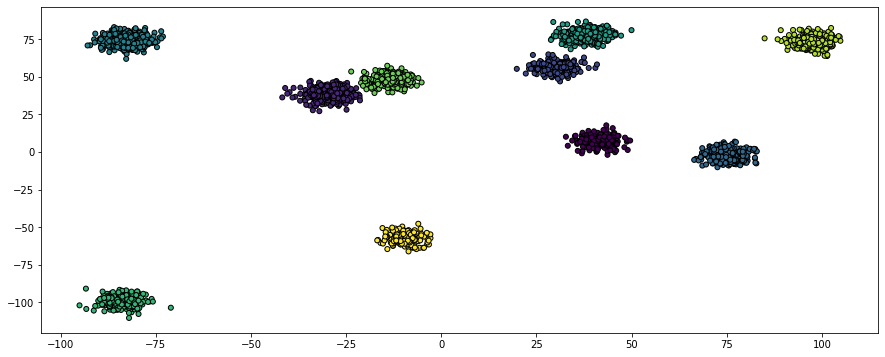

In [20]:
X, y, alpha_coef = generate_data(*generate_center_clusters(classes_numb=10, dim=2), alpha_coef=0)
print_clustering(X, y)

In [0]:
p1 = int(len(X)*0.7)
p2 = int(len(X)*0.8)
train_X, train_y = X[:p1, :], y[:p1]
val_X, val_y = X[p1:p2, :], y[p1:p2]
test_X, test_y = X[p2:, :], y[p2:]


In [0]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [0]:
loss_cel = nn.CrossEntropyLoss()
model = MLPModel() 
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [24]:
epochs = 1000
step = 200
accuracy, precision, recall, error, error_val = train(model, epochs, step, train_X, train_y, val_X, val_y)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch:  0 | Accuracy:  0.45662847790507366 | Precision:  0.3993449394879286 | Recall:  0.45662847790507366 | Loss:  248.41432189941406

Epoch:  200 | Accuracy:  0.9443535188216039 | Precision:  0.9441992425896499 | Recall:  0.9443535188216039 | Loss:  0.22661204636096954

Epoch:  400 | Accuracy:  0.9574468085106383 | Precision:  0.9566892062691871 | Recall:  0.9574468085106383 | Loss:  0.19036464393138885

Epoch:  600 | Accuracy:  0.9574468085106383 | Precision:  0.9566892062691871 | Recall:  0.9574468085106383 | Loss:  0.16776445508003235

Epoch:  800 | Accuracy:  0.9623567921440261 | Precision:  0.9617876913182852 | Recall:  0.9623567921440261 | Loss:  0.1523894965648651


[0.45662847790507366, 0.9443535188216039, 0.9574468085106383, 0.9574468085106383, 0.9623567921440261]


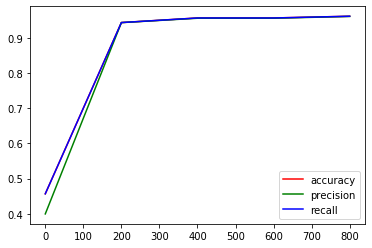

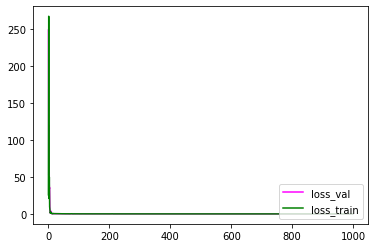

In [25]:
plot_metrics_error(step, epochs, accuracy, precision, recall, error_val, error)

# Сгенерируем новые данные dataset_4
Кол-во классов: 30, кол-во атрибутов: 2, линейно-неразделимое
Площадь пересечения >50%

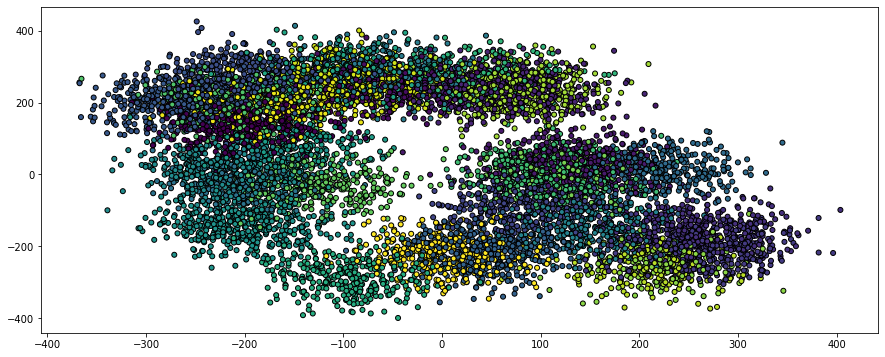

In [26]:
X, y, alpha_coef = generate_data(*generate_center_clusters(classes_numb=30, dim=2), alpha_coef=4)
print_clustering(X, y)

In [0]:
p1 = int(len(X)*0.7)
p2 = int(len(X)*0.8)
train_X, train_y = X[:p1, :], y[:p1]
val_X, val_y = X[p1:p2, :], y[p1:p2]
test_X, test_y = X[p2:, :], y[p2:]


In [0]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=30, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=30)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [0]:
loss_cel = nn.CrossEntropyLoss()
model = MLPModel() 
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [30]:
epochs = 1000
step = 100
accuracy, precision, recall, error, error_val = train(model, epochs, step, train_X, train_y, val_X, val_y)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch:  0 | Accuracy:  0.23919308357348704 | Precision:  0.07361377177863741 | Recall:  0.23919308357348704 | Loss:  183.03839111328125

Epoch:  100 | Accuracy:  0.39337175792507206 | Precision:  0.3223735384420844 | Recall:  0.39337175792507206 | Loss:  1.570513129234314

Epoch:  200 | Accuracy:  0.40297790585975024 | Precision:  0.35771146531040493 | Recall:  0.40297790585975024 | Loss:  1.4115791320800781

Epoch:  300 | Accuracy:  0.43419788664745435 | Precision:  0.3804045754526627 | Recall:  0.43419788664745435 | Loss:  1.3463751077651978

Epoch:  400 | Accuracy:  0.4274735830931796 | Precision:  0.36177988221050994 | Recall:  0.4274735830931796 | Loss:  1.3630177974700928

Epoch:  500 | Accuracy:  0.4332372718539865 | Precision:  0.3852394721945788 | Recall:  0.4332372718539865 | Loss:  1.3451957702636719

Epoch:  600 | Accuracy:  0.43756003842459174 | Precision:  0.41766817833607417 | Recall:  0.43756003842459174 | Loss:  1.339382290840149

Epoch:  700 | Accuracy:  0.4404418828

[0.23919308357348704, 0.39337175792507206, 0.40297790585975024, 0.43419788664745435, 0.4274735830931796, 0.4332372718539865, 0.43756003842459174, 0.4404418828049952, 0.4505283381364073, 0.4289145052833814]


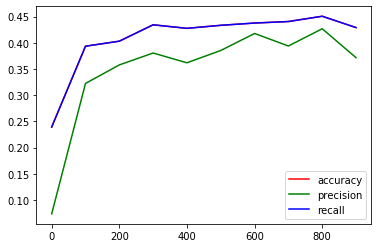

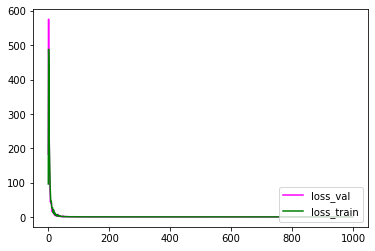

In [31]:
plot_metrics_error(step, epochs, accuracy, precision, recall, error_val, error)

# Сгенерируем новые данные - dataset_5
Кол-во классов: 10, кол-во аттрибутов: 2, линейно-нераздилимое (площадь пересечения 20-30%)

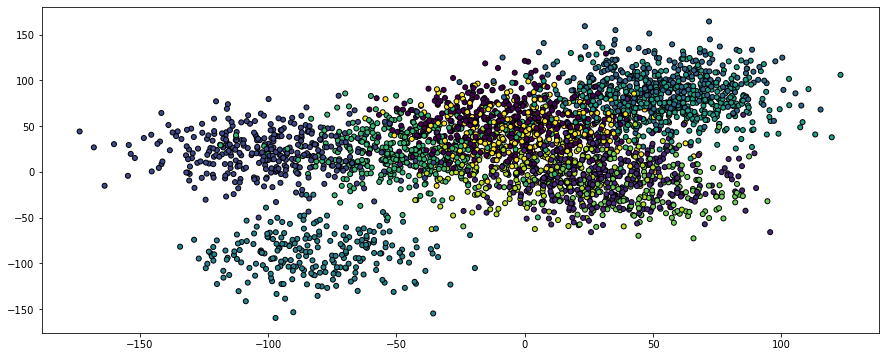

In [32]:
X, y, alpha_coef = generate_data(*generate_center_clusters(classes_numb=10, dim=2), alpha_coef=2)
print_clustering(X, y)

In [0]:
p1 = int(len(X)*0.7)
p2 = int(len(X)*0.8)
train_X, train_y = X[:p1, :], y[:p1]
val_X, val_y = X[p1:p2, :], y[p1:p2]
test_X, test_y = X[p2:, :], y[p2:]


In [0]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=100)
        self.linear3 = nn.Linear(in_features=100, out_features=10)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)
        x = self.relu(x)
        return x

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch:  0 | Accuracy:  0.13423831070889894 | Precision:  0.01829588002004901 | Recall:  0.13423831070889894 | Loss:  2.357950448989868

Epoch:  500 | Accuracy:  0.37104072398190047 | Precision:  0.27723851280008116 | Recall:  0.37104072398190047 | Loss:  1.5523061752319336

Epoch:  1000 | Accuracy:  0.39215686274509803 | Precision:  0.3004583068441616 | Recall:  0.39215686274509803 | Loss:  1.4950615167617798

Epoch:  1500 | Accuracy:  0.4072398190045249 | Precision:  0.3258269974656529 | Recall:  0.4072398190045249 | Loss:  1.469799518585205

Epoch:  2000 | Accuracy:  0.41025641025641024 | Precision:  0.33806247910975074 | Recall:  0.41025641025641024 | Loss:  1.447022795677185

Epoch:  2500 | Accuracy:  0.416289592760181 | Precision:  0.3460554321041414 | Recall:  0.416289592760181 | Loss:  1.4307236671447754

Epoch:  3000 | Accuracy:  0.416289592760181 | Precision:  0.3493344718812423 | Recall:  0.416289592760181 | Loss:  1.4168198108673096

Epoch:  3500 | Accuracy:  0.461538461538

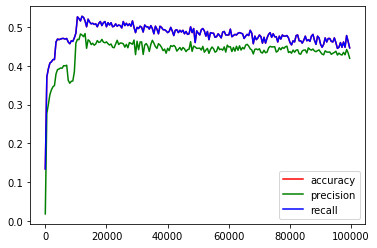

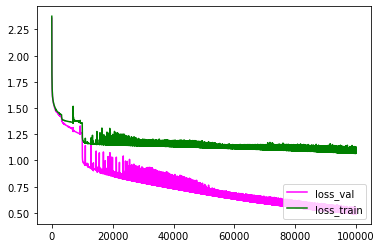

In [35]:
loss_cel = nn.CrossEntropyLoss()
model = MLPModel() 
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 100000
step = 500
accuracy, precision, recall, error, error_val = train(model, epochs, step, train_X, train_y, val_X, val_y)
plot_metrics_error(step, epochs, accuracy, precision, recall, error_val, error)

# Возьмем эталонное множество - iris.dataset

In [0]:
xy = np.loadtxt('./iris.txt',
                        delimiter=',', dtype=np.float32)
np.random.shuffle(xy)

X_train, X_test, X_val = np.split(xy, [int(.8 * len(xy)), int(.9 * len(xy))])

x_train = torch.FloatTensor(from_numpy(X_train[:, 0:-1])).to(device)
x_test = torch.FloatTensor(from_numpy(X_test[:, 0:-1])).to(device)
x_val = torch.FloatTensor(from_numpy(X_val[:, 0:-1])).to(device)

y_train = torch.FloatTensor(from_numpy(X_train[:, [-1]])).to(device)
y_test = torch.FloatTensor(from_numpy(X_test[:, [-1]])).to(device)
y_val = torch.FloatTensor(from_numpy(X_val[:, [-1]])).to(device)


In [0]:
# nn layers
linear1 = torch.nn.Linear(4, 100, bias=True)
linear2 = torch.nn.Linear(100, 3, bias=True)
sigmoid = torch.nn.Sigmoid()

# model
model = torch.nn.Sequential(linear1, sigmoid, linear2, sigmoid).to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3)
epochs = 1000
step = 100

In [50]:
accuracy=[]
error = []
error_val = []
for i in range(epochs):
    #===Train data===#
    model.train()
    optimizer.zero_grad()
    
    input_x = torch.tensor(x_train).float()
    true_y = torch.tensor(y_train).long()
    pred_y = model(input_x)
    loss = loss_cel(pred_y, true_y.squeeze(1).long())
    loss.backward()
    optimizer.step()
    error.append(loss.item())

    #===Validation data===#
    model.eval()
    optimizer.zero_grad()
    y_pred = model(x_val)

    loss = criterion(y_pred, y_val.squeeze(1).long())
    loss.backward()
    optimizer.step()
    error_val.append(loss.item())

    if i % 100 == 0:
      model.eval()
      print("\nEpoch: ", i, "| Loss_train: ", error[i], "| Loss_val: ", error_val[i] )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.



Epoch:  0 | Loss_train:  0.6677766442298889 | Loss_val:  0.6148675084114075

Epoch:  100 | Loss_train:  0.666814923286438 | Loss_val:  0.6143056154251099

Epoch:  200 | Loss_train:  0.6663236618041992 | Loss_val:  0.6140825748443604

Epoch:  300 | Loss_train:  0.6659500002861023 | Loss_val:  0.6139562129974365

Epoch:  400 | Loss_train:  0.6659031510353088 | Loss_val:  0.6137668490409851

Epoch:  500 | Loss_train:  0.6658422350883484 | Loss_val:  0.6137213110923767

Epoch:  600 | Loss_train:  0.6658075451850891 | Loss_val:  0.6136918663978577

Epoch:  700 | Loss_train:  0.6657647490501404 | Loss_val:  0.613671064376831

Epoch:  800 | Loss_train:  0.6656819581985474 | Loss_val:  0.6136557459831238

Epoch:  900 | Loss_train:  0.6655401587486267 | Loss_val:  0.6136440634727478


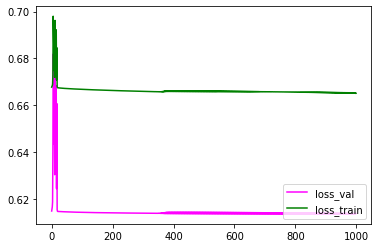

In [51]:
x = [i for i in range(epochs)]
plt.plot(x, error_val, color = 'magenta', label='loss_val')
plt.plot(x, error, color = 'green', label='loss_train')
plt.legend(loc='lower right')
plt.show()

Обе ошибки значительно больше 0, сеть недообучена